# Introduction

This project is based on the [PhysioNet/Cardiology (CinC) Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) and a Udacity course. The CINC challenge aimed to encourage the development of algorithms to classify, whether short single lead ECG recordings (between 30 s and 60 s in length) show normal sinus rhythm, atrial fibrillation (AF), an alternative rhythm, or is too noisy to be classified. The challenge data uses ECG recordings, collected using the AliveCor device, which were generously donated for this Challenge by AliveCor.



This training set contains single lead ECG recordings lasting from 9 s to just over 60 s. The recordings were sampled at 300 Hz and have been band pass filtered by the AliveCor device. Figure 1 shows the examples of the ECG waveforms (lasting for 20 s) for the four classes in this Challenge. From top to bottom, they are ECG waveforms of normal rhythm, AF rhythm, other rhythm and noisy recordings.

![Figure 1. Example of the ECG waveforms](figures/example_waveforms.svg)

In this project, we will start by building a simpler two-class classifier distinguishing between normal sinus rhythm and abnormal rhythms (atrial fibrillation included) by excluding the noisy recordings. We will thus use 7,418 out of the original 8,528 training data recordings. They have been converted into 'npz' format from the original MATLAB V4 WFDB-compliant format. 

We will perform the following 
1. Even though, RR intervals are already provided, we will first build an algorithm to extract RR intervals using the Pan-Tompkins method and measure the accuracy performance of our algorithm.
2. We will then process and extract features from the RR intervals data for our classifier.
3. Build and compute the performance of a 2-class random forest classifier

We will eventually take the challenge of 
1. Performing a grid search for hyperparameter tuning
2. Comparing different classifiers
2. Distinguishing between AF from alternative rhythm. This most likely will require extracting features other than RR intervals data, such as the presence/absence of P-wave (see Figure 2).

![Figure 2. Depiction of the QRS complex during the cardiac cycle (figure was obtained from https://en.wikipedia.org/wiki/Wiggers_diagram) ](figures/Wiggers_Diagram.png)





# Data Exploration

## Imports

In [24]:
import glob
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

np.warnings.filterwarnings('ignore')

## Load Raw ECG Data + QRS locations

The data is stored in `npz` files. We are given both the raw ECG data as well as the QRS complex locations.
We will also load cardiac rhythm labels even though this will only be used later for our classification algorithm.

In [25]:
fs = 300
data_dir = 'data/'
ref = pd.read_csv(data_dir + 'REFERENCE.csv')
ref = dict(zip(ref.record, ref.rhythm))
base = lambda f: os.path.splitext(os.path.basename(f))[0]
files = sorted(glob.glob(data_dir + '*.npz'))
ecgs, qrs, labels = [], [], []
for f in files:
    with np.load(f) as npz:
        ecgs.append(npz['ecg'])
        qrs.append(npz['qrs'])
    labels.append(ref[base(f)])


# Process and Extract RR data using the Pan-Tompkins Algorithm

Even though the QRS locations are given to us along with the ECG raw signal, we will be implementing the Pan-Tompkins Algorithm to compute those QRS complex locations on our own. We will then assess the performance of our algorithms by comparing the precision/recall accuracy against the QRS locations provided (within a 40ms toloerance window) 

## Pan-Tompkins Algorithm

The Pan-Tompkins algorithm is a series of pre-processing steps to amplify the QRS complex amplitude and a detection algorithm for finding these complexes. 

1. bandpass filtering between 5-15Hz to remove low and high freq content
2. Moving sum, first derivative (diff) and square to enhance the peaks
3. Find peaks
4. Remove non physiological peak by
    - removing peaks within 200ms of prior one due to refractory period
    - adaptive treshold keeping peak 70% above prior 8 peaks
    - remove T-wave by making sure that slope of following peak within 360ms is greater than half the prior one (T-wave are not as sharp)


In [26]:
def BandpassFilter(signal, fs=300):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (5, 15), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=300):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    # Didier: local maxima of neighboring 10 prior/later point)
    # Didier: find datapoints greater than order=10th earlier and later datapoints
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    # Didier: then make sure that this point is greater the all surrounding  
    # order=10 prior and later points     
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, peaks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[peaks])
    return peaks[filtered_signal[peaks] > thresh]

def AdaptiveThresholdPeaks(filtered_signal, peaks):
    # TODO: Implement adaptive thresholding
    # Make the detection threshold 70% of the average peak height for the last 8 peaks
    order = 8
    thresh_perc = 0.3 # was 0.7
    shift = 'No' # set to 'centered' for centered mean average
    # build data to be compared to by computing moving average using cumsum
    MApeak = np.cumsum(np.concatenate((np.zeros(order),filtered_signal[peaks]))) 
     # add -Inf as first element is compared to nothing
    # trying to use shift but need more working; discard
    if shift == 'centered':
        # trying to have a centered mean but need more working; discard
        MApeak = np.cumsum(np.concatenate((np.zeros(order),filtered_signal[peaks],np.zeros(order-1))))
        MApeak = np.concatenate(((float('-inf'),),MApeak[order:] - MApeak[:-order]
                      ,(filtered_signal[-1],)))[shift+1:len(MApeak)-int(order/2)]
    else:
        MApeak = np.concatenate(((float('-inf'),),MApeak[order:] - MApeak[:-order]))[:-1]
                     
    
    # build weight for computing average (first order=8 samples are compared to
    # the increasing number of prior samples from 1:order )
    # Used min to take care of situation where order>len(peaks)
    Weight = np.concatenate(((1,),np.arange(1,np.min((order+1,len(peaks))),1),
                             np.ones(np.max((0,len(peaks)-order-1)))*order))
    MApeak = np.divide(MApeak,Weight)
    peaks_new = peaks[filtered_signal[peaks] > thresh_perc * MApeak ]
    
    # plt.figure()
    # ts = np.arange(len(filtered_signal))/300
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks],filtered_signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Adaptive Threshold Peaks')
    # plt.show()
    # plt.waitforbuttonpress()

    return peaks_new
    # need to add the first 8 peaks
    # for pks in range(0:order+1):
    #     msk &= filtered_signal[peaks[order:]]>thresh_perc * filtered_signal[peaks[:-order]]]
    # return peaks[filtered_signal[peaks]>thresh_perc * filtered_signal[peaks[:-order]]]
    
def RefractoryPeriodBlanking(filtered_signal, peaks, fs, refractory_period_ms=200):
    # TODO: Implement refractory period blanking
    #select all peaks within refractory_period_ms
    peaks_new = peaks
    # idx_refrac = np.where(np.diff(peaks_new) < refractory_period_ms/1000*fs)[0]
    # idx_refrac = np.unique(np.concatenate((idx_refrac,idx_refrac+1)))
    idx_refrac =0
    
    # plt.figure()
    # ts = np.arange(len(filtered_signal))/fs
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.k',ms=7)
    # ref_line = plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Refractory Period Blanking')
    # plt.show()
    
    while idx_refrac  != []:
        # find and delete smallest peaks in all refractory regions  
        # find indices of all peaks within a refractory_period_ms distance of another
        idx_refrac = np.where(np.diff(peaks_new) < refractory_period_ms/1000*fs)[0]
        idx_refrac = np.unique(np.concatenate((idx_refrac,idx_refrac+1)))
        # delete the smallest peak and continue until no more peaks in refractory regions
        if idx_refrac  != []:
            idx_del = idx_refrac[np.argmin(filtered_signal[peaks_new[idx_refrac]])]
            peaks_new = np.delete(peaks_new,idx_del)

        # line = ref_line.pop(0)
        # line.remove()
        # ref_line = plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
        # plt.show()
        # plt.waitforbuttonpress()
    
    # plt.clf    
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks],filtered_signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Refractory Period Blanking')
    # plt.show() 
    # plt.waitforbuttonpress()       
    
    return peaks_new

def TWaveDiscrimination(signal, peaks, fs, twave_window_ms=360, slope_window_ms=60):
    # TODO: Implement t-wave discrimination
    # Find peaks that follow a previous one by 360ms or less
    peaks_new = peaks
    slope_window = int(slope_window_ms/1000*fs)
    for tmp,idx in enumerate(np.where(np.diff(peaks) < twave_window_ms/1000*fs)[0]):
    # same as 
    # for i, idx in enumerate(j for j in range(len(peaks)-1) if (np.diff(peaks)[j] < twave_window_ms/1000*fs))
        max_slope1 = np.max(np.abs(np.diff(signal[peaks[idx] - slope_window:
                                                 peaks[idx] + slope_window])))
        max_slope2 = np.max(np.abs(np.diff(signal[peaks[idx+1] - slope_window:
                                                     peaks[idx+1] + slope_window])))
        if max_slope2   < 0.5* max_slope1:
            np.delete(peaks_new,idx+1)
            
    # plt.figure()
    # ts = np.arange(len(signal))/fs
    # plt.plot(ts,signal,'b')
    # plt.plot(ts[peaks],signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],signal[peaks_new],'.r',ms=7)
    # plt.title('Twave Discrimination')
    # plt.show()  
    # plt.waitforbuttonpress()    
            
    return peaks_new
                  
def PanTompkinsPeaks(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    peaks = FindPeaks(filtered_signal)
    peaks = RefractoryPeriodBlanking(filtered_signal, peaks, fs)  # TODO: Uncomment this line
    #peaks = ThresholdPeaks(filtered_signal, peaks)                 # TODO: Remove this line
    peaks = AdaptiveThresholdPeaks(filtered_signal, peaks)        # TODO: Uncomment this line
    peaks = TWaveDiscrimination(signal, peaks, fs)                # TODO: Uncomment this line
    return peaks


## Performance Evaluation Helpers

Let's first build a function that tells us the performance of our QRS estimates.

In [27]:
def Evaluate(reference_peak_indices, estimate_peak_indices, tolerance_samples=40):
    """Evaluates algorithm performance for a single dataset.
    
    It is not expected that reference and estimate peak indices overlap exactly.
    Instead say a QRS estimate is correct if it is within <tolerance_samples> of
    a reference estimate.
    
    Args:
        reference_peak_indices: (np.array) ground-truth array of QRS complex locations
        estiamte_peak_indices: (np.array) array of QRS complex estimates
        tolerance_samples: (number) How close a QRS estimate needs to be to a reference
            location to be correct.
    Returns:
        n_correct: (number) The number of QRS complexes that were correctly detected
        n_missed: (number) The number of QRS complexes that the algorithm failed
            to detect
        n_extra: (number) The number of spurious QRS complexes detected by the
            algorithm
    """
    # Keep track of the number of QRS peaks that were found correctly
    n_correct = 0
    # ... that were missed
    n_missed = 0
    # ... and that are spurious
    n_extra = 0
    
    # Loop counters
    i, j = 0, 0
    while (i < len(reference_peak_indices)) and (j < len(estimate_peak_indices)):
        # Iterate through the arrays of QRS peaks, counting the number of peaks
        # that are correct, missed, and extra.
        ref = reference_peak_indices[i]
        est = estimate_peak_indices[j]
        if abs(ref - est) < tolerance_samples:
            # If the reference peak and the estimate peak are within <tolerance_samples>,
            # then we mark this beat correctly detected and move on to the next one.
            n_correct += 1
            i += 1
            j += 1
            continue
        if ref < est:
            # Else, if they are farther apart and the reference is before the estimate,
            # then the detector missed a beat and we advance the reference array.
            n_missed += 1
            i += 1
            continue
        # Else, the estimate is before the reference. This means we found an extra beat
        # in the estimate array. We advance the estimate array to check the next beat.
        j += 1
        n_extra += 1
    # Don't forget to count the number of missed or extra peaks at the end of the array.
    n_missed += len(reference_peak_indices[i:])
    n_extra += len(estimate_peak_indices[j:])
    return n_correct, n_missed, n_extra

Now we need a function that can compute precision and recall for us.

In [28]:
def PrecisionRecall(n_correct, n_missed, n_extra):
    # TODO: Compute precision and recall from the input arguments.
    precision = n_correct/(n_correct + n_extra) # true positive / (true positive+false positive) -> do not want diagnose extra 
    recall = n_correct/(n_correct + n_missed)  # true positive / (true positive + false negative) -> do not want to miss  
    return precision, recall

## Evaluate Performance 

Using the PrecisionRecall function above, we will compute an overall precision and recall for QRS detection. 

In [29]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [30]:
# Keep track of the total number of correct, missed, and extra detections.
total_correct, total_missed, total_extra = 0, 0, 0

for i, fl in enumerate(files):
    # For each file, load the data...
    
    ecg = ecgs[i]
    reference_peak_indices = qrs[i]
    
    #with np.load(fl) as npz:
    #    ecg = npz['ecg']
    #    reference_peak_indices = npz['qrs']
    # Compute our QRS location estimates...
    estimate_peak_indices = PanTompkinsPeaks(ecg, fs)

    # Compare our estimates against the reference...
    n_correct, n_missed, n_extra = Evaluate(reference_peak_indices, estimate_peak_indices)

    # You can uncomment this line if you want to compare ECG peak detection with ECG ref
    # plt.clf()
    # ts = np.arange(len(ecg))/fs 
    # plt.plot(ts,ecg,'b')
    # plt.plot(ts[estimate_peak_indices],ecg[estimate_peak_indices],'r.',ms=5)
    # plt.plot(ts[reference_peak_indices],ecg[reference_peak_indices],'k+',ms=5)
    # plt.title(fl[-10:-4] + '(missed:' + str(n_missed) + ',extra:' + str(n_extra) + ")" )
    # plt.show()
    # plt.pause(1)
    # plt.waitforbuttonpress()
    
    # And add them to our running totals.
    total_correct += n_correct
    total_missed += n_missed
    total_extra += n_extra
    print('\r{}/{} files processed...'.format(i+1, len(files)), end='')
print('') # print a newline

# Compute and report the overall performance.
precision, recall = PrecisionRecall(total_correct, total_missed, total_extra)
print('Total performance:\n\tPrecision = {:0.2f}\n\tRecall = {:0.2f}'.format(precision, recall))

7416/7416 files processed...
Total performance:
	Precision = 0.93
	Recall = 0.99


The performance of our algorithm is reasonable with a 93% precision and 99% recall, i.e. the ability to correctly detect 93% of the peaks with 1% of them being wrongly detected as a QRS peak (false positive) 

In [31]:
%matplotlib inline

# AF classifier

In this section, we will be create a Random Forest Classifier to classify normal from abnormal ECG rhythms. We will first extract features mainly from the RR interval time series, and then compute the performance of the algorithm. 

We will first create a model using a max depth of 4 and 100 trees, before optimizing hyperparameters using a grid search.

## Features

The features for the AF detection algorithm are computed from the RR interval time series. We use the time domain and frequency domain features listed below.

### Time domain
 - minimum RR interval
 - maximum RR interval
 - median RR interval
 - average RR interval
 - standard deviation of RR intervals
 - number of RR interval outliers
   - An RR interval is an outlier if it is greater than 1.2x the average RR interval in the ECG record
 - root-mean-square of the difference between adjacent RR intervals
 - percent of RR interval differences greater than 50 milliseconds

### Frequency domain
The RR interval time series is not sampled regularly in time. We only have a datapoint every heart beat. Before we can compute any frequency domain features, the time series must be resampled so that we get uniform data points. Resample the RR interval time series to 4 Hz before computing the features below.

 - peak magnitude between 0.04 Hz and 0.15 Hz in the regularized RR interval time series
 - main frequency between 0.04 Hz and 0.15 Hz in the regularized RR interval time series
 - peak magnitude between 0.15 Hz and 0.4 Hz in the regularized RR interval time series
 - main frequency between 0.15 Hz and 0.4 Hz in the regularized RR interval time series

In [32]:
def Featurize(qrs_inds, fs):
    """Featurize the qrs complex locations time series.

    Args:
        qrs_inds: (np.array of number) the sample indices of the QRS complex locations
        fs: (number) the sampling rate

    Returns:
        n-tuple of features
    """
    # Compute the RR interval time series in s
    RR = np.diff(qrs_inds)/fs
    
    # Compute time domain features
    min_rr = np.min(RR)
    max_rr = np.max(RR)
    median_rr = np.median(RR)
    mean_rr = np.mean(RR)
    std_rr = np.std(RR)
    n_outliers = np.sum(RR>1.2*mean_rr)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR))))
    pdrr_50 = 100*np.mean(np.diff(RR)>0.05)

    # Regularly resample the RR interval time series (done in terms of samples)
    fsi = 4 #resampling at 4Hz
    tsi = np.arange(qrs_inds[0]/fs, qrs_inds[-2]/fs, 1/fsi)
    RRi = np.interp(tsi,qrs_inds[:-1]/fs,RR)



    # Compute the Fourier transform of the regular RR interval time series
    freq = np.fft.rfftfreq(len(RRi), 1 / 4)
    fft_mag = np.abs(np.fft.rfft(RRi))

    # Compute frequency domain features
    ############# Didier
    # There was an error in the original solution
    # The size of the data within a certain freq band is smaller than the whole frequency data range
    # As such, the index pointing to the maximum of a freq band should be with respect to that freq band (not the whole range of freq)
    lf_mag = np.max(fft_mag[(freq >= 0.04) & (freq <= 0.15)])
    #lf_freq = freq[np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]  #<- error
    lf_freq = freq[(freq >= 0.04) & (freq <= 0.15)][np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]
    hf_mag = np.max(fft_mag[(freq >= 0.15) & (freq <= 0.4)])
    #hf_freq = freq[np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])] #<- error
    hf_freq = freq[(freq >= 0.15) & (freq <= 0.4)][np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])]


    return (min_rr, max_rr, median_rr, n_outliers, mean_rr, std_rr, rmssd, pdrr_50,
            lf_mag, lf_freq, hf_mag, hf_freq)

## Create Feature Matrix

In trying to run Featurize on our data, curiously record 4682 was found to have not qrs?
Let's first compute them using our algorithm

[]


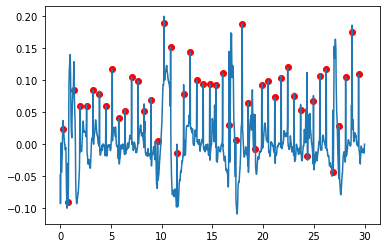

In [33]:
# For some reason record 4682 doesn't have any qrs ???
# Compute it using our algorithm
print(qrs[4682])

qrs[4682] = peaks = PanTompkinsPeaks(ecgs[4682], fs)
ts = np.arange(len(ecgs[4682]))/fs
plt.plot(ts,ecgs[4682]);
plt.scatter(ts[peaks],ecgs[4682][peaks],color='r');

In [34]:
feats = [Featurize(qrs_inds, fs) for qrs_inds in qrs]      
X, y = np.array(feats), np.array(labels)
print(X.shape)

(7416, 12)


## Build a Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, StratifiedKFold



Accuracy from fitting the entire dataset=0.813, Accuracy from CV=0.807 (0.015)
Verify: Accuracy from fitting the entire dataset=0.813, Accuracy from CV=0.807 (0.015)
Precision CV=0.800 (0.016), Recall CV=0.808 (0.013)


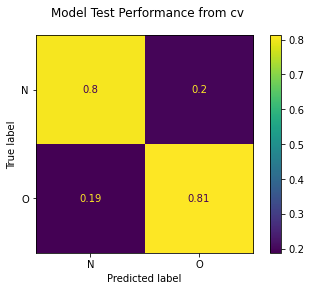

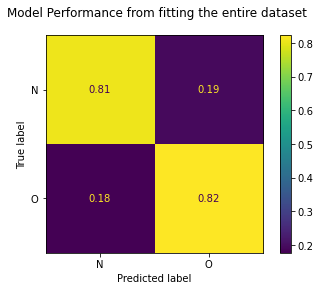

In [36]:
# TODO:
# Write code that builds and trains a classifier to classify our ECG records.
# Again, a random forest with 100 trees and a depth of 4 works well.
# Evaluate the performance of the classifier using K-Fold cross validation stratified by classes.

## Building the model
skf = StratifiedKFold(n_splits=5)

clf = RandomForestClassifier(n_estimators=100, max_depth=4, 
                               random_state=42, class_weight='balanced')
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# execute cross-validation
accuracy_cv = cross_val_score(clf, X, y, cv=skf)
ypred_cv = cross_val_predict(clf, X, y, cv=skf)
# scoring = ['precision_macro']
scores = cross_validate(clf, X, y, cv=skf, scoring = scoring, return_train_score=True, return_estimator=True)

# evaluate model on the whole  dataset
result = clf.fit(X,y)
ypred = clf.predict(X)

# evaluate the model
accuracy = accuracy_score(y, ypred)


## Final model and its performance
print('Accuracy from fitting the entire dataset=%.3f, Accuracy from CV=%.3f (%.3f)' 
      % (accuracy, np.mean(accuracy_cv), np.std(accuracy_cv)))

print('Verify: Accuracy from fitting the entire dataset=%.3f, Accuracy from CV=%.3f (%.3f)' 
      % (accuracy, np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

print('Precision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (np.mean(scores['test_precision_macro']), np.std(scores['test_precision_macro']),
        np.mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))

disp = ConfusionMatrixDisplay.from_predictions(y, ypred_cv, normalize='true') 
disp.figure_.suptitle("Model Test Performance from cv");

disp = ConfusionMatrixDisplay.from_predictions(y, ypred, normalize='true') 
disp.figure_.suptitle("Model Performance from fitting the entire dataset");

Let's see if we can improve on this model using a gridsearch

In [41]:

# defining the hyperparameters grid
grid = {'n_estimators' : [2, 10, 20, 50, 100, 150, 300],'max_depth' : np.array(range(1, 7))}
# define model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Define Kfold 
skf = StratifiedKFold(n_splits=5)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# define search
search = GridSearchCV(clf, grid, scoring=scoring, cv=skf, refit="accuracy")
# execute search
result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_clf = result.best_estimator_

# Perform CV on best_clf
accuracy_cv = cross_val_score(best_clf, X, y, cv=skf)
ypred_cv = cross_val_predict(best_clf, X, y, cv=skf)
# evaluate model on the whole  dataset
ypred = best_clf.predict(X)

# evaluate the model
accuracy = accuracy_score(y, ypred)

best_hyper_params = (result.best_params_['n_estimators'], result.best_params_['max_depth'])

Then compute and display the model performance

Final best model using full dataset and its performance:

Max Depth (max_depth)=6, Number of Trees in the Forest (n_estimators)=50 
Accuracy from fitting the entire dataset=0.844, Accuracy from CV=0.831 (0.006)

Verify that we are obtaining the same thing from gridsearch: Estimated accuracy (entire dataset)=0.844, Average estimated Accuracy from CV=0.831 (0.006)

Precision CV=0.823 (0.008), Recall CV=0.825 (0.008)


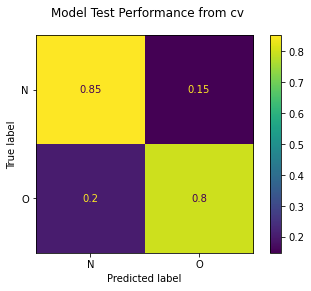

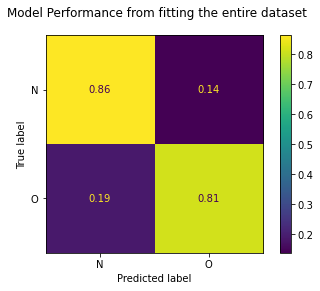

In [49]:
# evaluate the model
accuracy = accuracy_score(y, ypred)

best_hyper_params = (result.best_params_['n_estimators'], result.best_params_['max_depth'])

print('Final best model using full dataset and its performance:')
print('\nMax Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result.best_params_['max_depth'],result.best_params_['n_estimators']))

## Final model and its performance
print('Accuracy from fitting the entire dataset=%.3f, Accuracy from CV=%.3f (%.3f)' 
      % (accuracy, np.mean(accuracy_cv), np.std(accuracy_cv)))

i_best = np.argmax(result.cv_results_['mean_test_accuracy'])
print('\nVerify that we are obtaining the same thing from gridsearch: Estimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from CV=%.3f (%.3f)' % 
       (accuracy, result.cv_results_['mean_test_accuracy'][i_best],
         result.cv_results_['std_test_accuracy'][i_best]))


print('\nPrecision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (result.cv_results_['mean_test_precision_macro'][i_best], result.cv_results_['std_test_precision_macro'][i_best],
        result.cv_results_['mean_test_recall_macro'][i_best], result.cv_results_['std_test_recall_macro'][i_best]))


disp = ConfusionMatrixDisplay.from_predictions(y, ypred_cv, normalize='true') 
disp.figure_.suptitle("Model Test Performance from cv");

disp = ConfusionMatrixDisplay.from_predictions(y, ypred, normalize='true') 
disp.figure_.suptitle("Model Performance from fitting the entire dataset");



The gridsearch found that Random Forest classifier using a max depth of 6 and 50 trees provides the best performance resulting in a slight improvement from our initial model (max depth of 4, 100 trees)  in all 3 metrics i.e. accuracy (from 0,81 to 0.83), precision (from 0.8 to 0.82) and Recall (from 0.81 to 0.83).

Let's visualize the results by plotting the decision regions and boundaries by projecting the high dimensional feaures space into 2 main components using tSNE (t-distributed stochastic neighbor embedding) dimensionality reduction techniques. 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.002s...
[t-SNE] Computed neighbors for 500 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.581429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.858402
[t-SNE] KL divergence after 300 iterations: 0.344744


Text(0.5, 1.0, 'Decision Boundary Using t-SNE')

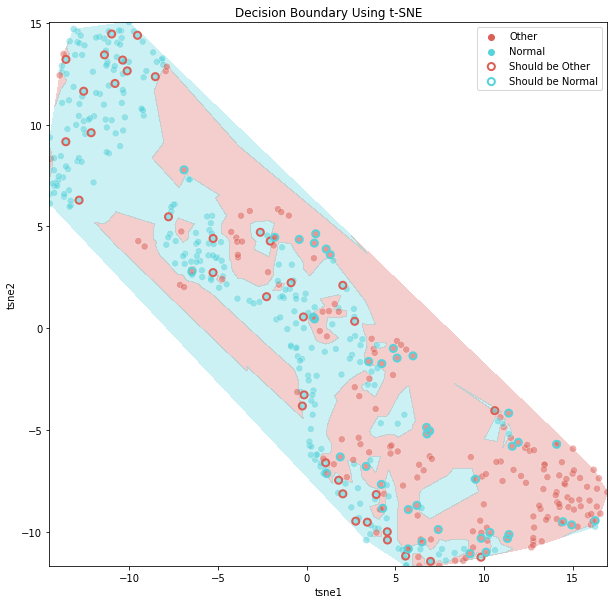

In [121]:
#from sklearn.inspection import DecisionBoundaryDisplay

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# define palettes 
palette = sns.color_palette("hls", 2)
class_names = np.array(['O','N'])
class_names2 = np.array(['Other','Normal'])
hue_order = class_names
my_cmap = ListedColormap(palette.as_hex())

# plot first decision boundary regions by assigning 0 for bike, 1 for run and 2 for walk
# Note that the use of tricontourf to draw regions separated by th boundary 0.5 and 1.5 
# is not quite accurate as it forces to create a run/green (label =1) region between 
# bike/red (level 0) and bike/blue (level 2). To be fixed later... 
ypred_num = np.empty(np.size(ypred))
for i,label in enumerate(class_names):
    ypred_num[ypred==label]=i

##### TSNE projection to keep the top 2 components for 2D scatter plots
# create a random sample of size 500
isel = np.random.choice(len(X), 500, replace=False)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300);
X_tsne = tsne.fit_transform(X[isel])
df_tsne = pd.DataFrame(X_tsne,columns=["tsne1","tsne2"]) 

plt.figure(figsize=(10,10))

# plot first decision boundary regions
plt.tricontourf(X_tsne[:,0],X_tsne[:,1],ypred_num[isel],levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 

ax = sns.scatterplot(x="tsne1", y="tsne2",data=df_tsne,
                hue=ypred[isel], palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.5)


# finally highlight incorrectly labeled data with an outer colored edge around the marker

for i,label in enumerate(class_names): 
    plt.scatter(X_tsne[(ypred[isel]!=y[isel]) & (y[isel]==label), 0], X_tsne[(ypred[isel]!=y[isel]) & (y[isel]==label), 1],
            s=50, facecolor = 'none', edgecolor=palette[i],marker="o",lw=2,label="Should be "+ class_names2[i])

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Other','Normal', 'Should be Other','Should be Normal'])
ax.set_title('Decision Boundary Using t-SNE')

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765), (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]


list

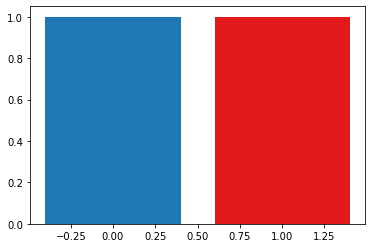

In [115]:
palette = sns.color_palette("Paired", 8)
palette= [palette[1],palette[5]]
print(palette)
plt.bar([0,1],[1,1], color=palette)
type(palette)


Clearly there is still a lot of overlap between `Other` and `Normal` rhythm classes, suggesting that the model may benefit from adding additional features.